In [1]:
#%matplotlib widget
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import pandas as pd
import re
import parse



vars = {"vas" : "northward near-surface wind (m.s-1)",
"uas":"eastward near-surface wind (m.s-1)",
"tas":"2-meter air temperature (degC)",
"pr": "total precipitation amount (mm)",
"rsds" : "surface downwelling shortwave radiation (W.m-2)",
"rlds" : "surface downwelling longwave radiation (W.m-2)",
"hurs" : "2-meter relative humidity (%)"    
}

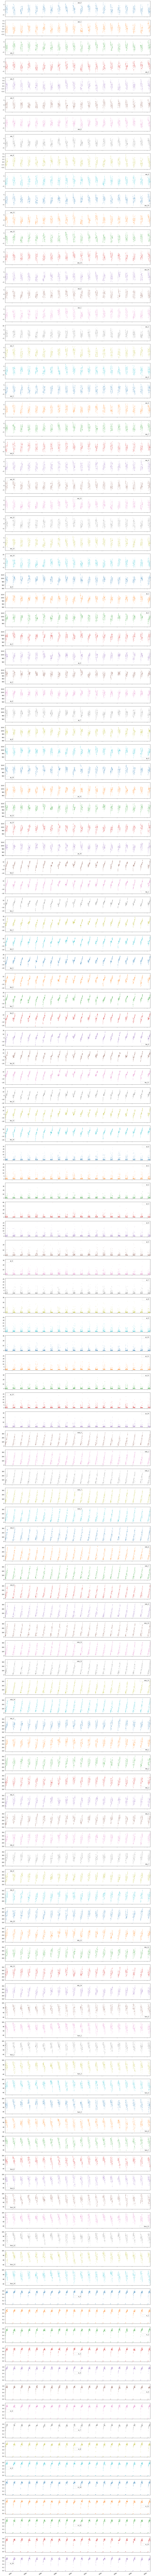

In [2]:
readRDS = robjects.r['readRDS']
df = readRDS('era_system4_spring.rds')
df = pandas2ri.ri2py(df)


p = parse.compile('''[1] "{var}"\n''')
#Only need to parse the date once, I like to live dangerously
date = [datetime.datetime.strptime(date,'%Y-%m-%d GMT') for date in df[0][3][0]]

# for i in df:
#     date = [datetime.datetime.strptime(date,'%Y-%m-%d GMT') for date in i[3][0]]
#     data = [float(i) for i in i[1]]
#     var = p.parse(str(i[0][0]))['var']


#data = [float(i) for i in df[8][1]]

# plt.figure(figsize=(20,5))
# plt.plot(data,marker='.',markersize=0.5,linestyle='None')
# cnt=0
# for i in df[0]:
#     display(cnt,i)
#     cnt = cnt + 1

# date = [datetime.datetime.strptime(date,'%Y-%m-%d GMT') for date in df[1][3][0]]
# data = np.reshape(data,(2405,15))

# myDf = pd.DataFrame(data=data,    # values
#               index=date,
#             columns = ['uas_{}'.format(i) for i in range(15)])    # 1st column as index

# myDf.plot(subplots=True,figsize=(20,45),linestyle='None',marker = '.')
winter_df =  pd.DataFrame()
for i in df:
#     date=[datetime.datetime.strptime(date,'%Y-%m-%d GMT') for date in i[3][0]]
    data = [float(i) for i in i[1]]
    data = np.reshape(data,(2405,15))
    var = p.parse(str(i[0][0]))['var']
    dummy = pd.DataFrame(data=data,   
              index=date,
              columns = ['{}_{}'.format(var,i) for i in range(15)])
    winter_df = pd.merge(winter_df,dummy,how='outer',left_index=True,right_index=True)
   
    
winter_df.plot(subplots=True,figsize=(20,winter_df.shape[1]*3),marker='.',markersize=1,linestyle='None')
plt.savefig('winter_system4.png')

In [ ]:
readRDS = robjects.r['readRDS']
df = readRDS('erainterim_bias_bc_cross.rds')
df = pandas2ri.ri2py(df)

dates = df[0][3][1]
dates = ','.join(dates).split(',')
dates  = [datetime.datetime.strptime(date, '%Y-%m-%d GMT').date() for date in dates]
display(len(dates))
era = pd.DataFrame(index=dates)
for i in df:
    name = str(i[0][0]).strip()
    values = [float(i) for i in i[1]]
    display(name,len(values))
    era[name] = values[:len(dates)]

era.rename(columns=lambda x: re.sub('^\[1\] ','',x),inplace=True)    
era.rename(columns=lambda x: re.sub('"','',x),inplace=True)     
    
era.plot(subplots=True,figsize=(20,20))
plt.savefig('eraInterim.png')
era.to_csv('eraInterim_bias_corrected with ewembi.csv')

display(era.mean(axis=0))

# fig = plt.gcf()
# fig.canvas.layout.width = '100%'
# fig.canvas.layout.height = '2000px'

In [ ]:
readRDS = robjects.r['readRDS']
df = readRDS('ewembi.rds')
df = pandas2ri.ri2py(df)
dates = df[0][3][1]
dates = ','.join(dates).split(',')
dates  = [datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S GMT').date() for date in dates]
ewembi = pd.DataFrame(index=dates)
ewembi.index = pd.to_datetime(ewembi.index)
for i in df:
    name = str(i[0][0]).strip()
    display(name)
    values = [float(i) for i in i[1]]
    ewembi[name] = values

ewembi.rename(columns=lambda x: re.sub('^\[1\] ','',x),inplace=True)    
ewembi.rename(columns=lambda x: re.sub('"','',x),inplace=True)  


ewembi.plot(subplots=True,figsize=(20,5))
plt.savefig('ewembi.png')
ewembi.to_csv('ewembi.csv')

# fig = plt.gcf()
# fig.canvas.layout.width = '100%'
# fig.canvas.layout.height = '2000px'

## Loading observed data
Precipitation and temperature from the nordic gridded dataset.
Station data queried using the frost.met.no api (station data).


In [ ]:
import pickle
#Gridded dataset
metno_gridded_temperature =  pd.read_csv('Vansjø_temperature.csv',index_col=0)
metno_gridded_precip = pd.read_csv('Vansjø_rain.csv',index_col=0)
metno_gridded_temperature.index = pd.to_datetime(metno_gridded_temperature.index)
metno_gridded_precip.index = pd.to_datetime(metno_gridded_precip.index)
metno_gridded_temperature.index = [datetime.datetime(i.year,i.month,i.day) for i in metno_gridded_temperature.index]
metno_gridded_precip.index = [datetime.datetime(i.year,i.month,i.day) for i in metno_gridded_precip.index]

#Observed station data
metno_station_data = pd.read_pickle('metno.pickle')
metno_station_data[1]['radiation'] = metno_station_data[1]['radiation'].resample('d').apply(lambda x : np.nanmean([max(0,i) for i in x]) if sum(np.isnan(x)) < 3 else np.nan )
#Averaging station data
cnd = True
for key,df in metno_station_data[1].items():
    #display(type(df.mean(axis=1).to_frame()))
    if cnd:
        average_station_data = df.mean(axis = 1).to_frame()
        average_station_data.index = [datetime.datetime(i.year,i.month,i.day) for i in average_station_data.index]
        average_station_data.columns = {key}
        cnd = False
    else:
        appendix = df.mean(axis=1).to_frame()
        appendix.columns = {key}
        appendix.index = [datetime.datetime(i.year,i.month,i.day) for i in appendix.index]
        average_station_data = pd.merge(average_station_data,appendix,how='outer',left_index=True,right_index=True)
        
average_station_data.plot(subplots=True,linestyle='None',marker='.',markersize=1,figsize=(20,20))        
# fig = plt.gcf()
# fig.canvas.layout.width = '100%'
# fig.canvas.layout.height = '2000px'

In [ ]:
era5_temperature =  pd.read_csv('Vansjø_temperature_era5.csv',index_col=0)
era5_precip = pd.read_csv('Vansjø_rain_era5.csv',index_col=0)
era5_temperature.index = pd.to_datetime(era5_temperature.index)
era5_precip.index = pd.to_datetime(era5_precip.index)
era5_temperature.index = [datetime.datetime(i.year,i.month,i.day) for i in era5_temperature.index]
era5_precip.index = [datetime.datetime(i.year,i.month,i.day) for i in era5_precip.index]

In [ ]:
#Comparing precipition
precip = pd.merge(ewembi.pr,era.pr,how='outer',left_index=True,right_index=True)
precip.columns = {'ewembi','era-interim'}
precip = pd.merge(precip,average_station_data['precipitation'],how='outer',left_index=True,right_index=True)
precip = pd.merge(precip,metno_gridded_precip,how='outer',left_index=True,right_index=True)
precip = pd.merge(precip,era5_precip,how='outer',left_index=True,right_index=True)

precip.rename(columns = {'precipitation' : 'observed', 'RR' : 'gridded', 'tp' : 'era5'},inplace=True)

precip.plot(subplots=True,figsize=(20,20))
display(precip.mean())
# fig = plt.gcf()
# fig.canvas.layout.width = '100%'
# fig.canvas.layout.height = '2000px'

In [ ]:
precip.dropna().resample('Y').sum().plot(figsize = (20,5))
fig = plt.gcf()
fig.savefig('precip.png')

In [ ]:
temperature = {}
temperature = pd.merge(ewembi.tas,era.tas,how='outer',left_index=True,right_index=True)
temperature.columns = {'ewembi','era-interim'}
temperature = pd.merge(temperature,average_station_data['air_temperature'],how='outer',left_index=True,right_index=True)
temperature = pd.merge(temperature,metno_gridded_temperature,how='outer',left_index=True,right_index=True)
temperature = pd.merge(temperature,era5_temperature,how='outer',left_index=True,right_index=True)

temperature.rename(columns = {'air_temperature' : 'observed', 'TG' : 'gridded', 't2m' : 'era5'},inplace=True)

temperature.plot(subplots=True,figsize=(20,20))
display(temperature.mean())

In [ ]:
temperature.dropna().resample('Y').mean().plot(figsize = (20,5))
fig = plt.gcf()
fig.savefig('temp.png')

In [ ]:
p = precip.dropna()
p = p.resample('m').sum()
p = p.groupby(lambda x : x.month).mean()
p = p.subtract(p.gridded,axis='index')
p.plot(figsize=(10,10))

In [ ]:
t = temperature.dropna()
t = t.resample('m').mean()
t = t.groupby(lambda x : x.month).mean()
t = t.subtract(t.gridded,axis='index')
t.plot(figsize=(10,10))

In [ ]:
temperature.loc[datetime.datetime(2005,1,1):datetime.datetime(2005,3,1),['era-interim','era5','gridded']].plot(figsize=(15,5))

In [ ]:
precip.loc[datetime.datetime(1988,1,1):datetime.datetime(1988,3,1),['era-interim','era5','gridded']].plot(figsize=(15,5))

In [ ]:
subset = precip.loc[datetime.datetime(1985,1,1):datetime.datetime(1985,3,1),['era-interim','era5','gridded']]
subset.subtract(subset.era5,axis='index').plot(figsize=(15,5))